# K-Min-Sum-Radii LP proof of concept

The goal is to find the optimal solution to a linear program that calculates a k-msr solution to a given selection of points and an integer k. Gurobi is used to calculate the solution within the necessary constraints. This notebook is supposed to be an exercise to find these specific constraints and to improve my grasp on the problem itself, before proceeding with implementing an algorithm of my own.

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric

We need data points to perform the clustering on. An easy stand-in for actual data are sklearn blobs, that form very obvious clusters and are verifiable by hand if they are small enough.

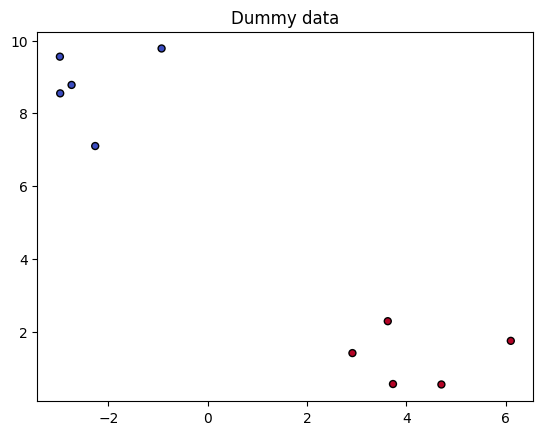

In [11]:
# generate dummy data for k=2
k = 2
points, cluster_membership = make_blobs(
    n_samples=10,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()

## Defining the ILP

In [12]:
# distance function
dist = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = dist.pairwise(points)

In [13]:
# model
m = gp.Model("kmsr")

# variables
R = m.addVars(len(radii), vtype=GRB.CONTINUOUS, lb=0, name="R")
L = m.addVars(len(radii), vtype=GRB.BINARY, name="L")
Y = m.addVars(len(radii), len(radii), vtype=GRB.BINARY, name="Y")

In [14]:
# objective function: minimize sum of r in R_i of i in L: y_{i,r}*r
m.setObjective(gp.quicksum(R[i] for i in range(len(radii))), GRB.MINIMIZE)

In [15]:
# constraints:
# every point covered
for j in range(len(radii)):
    m.addConstr(gp.quicksum(Y[i, j] for i in range(len(radii))) >= 1, f"coverage_{j}")

# covered point has to be within radius (easier to check in two steps than in the first constraint)
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(radii[i][j] * Y[i, j] <= R[i], f"within_radius_{i}_{j}")

# if a point is covered by a center, that center must be open in this iteration
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(Y[i, j] <= L[i], f"open_center_{i}_{j}")

# there can only be k centers open at a time
m.addConstr(gp.quicksum(L[i] for i in range(len(radii))) == k, "select_k_Centers")

<gurobi.Constr *Awaiting Model Update*>

In [16]:
# run gurobi optimizer
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 211 rows, 120 columns and 500 nonzeros
Model fingerprint: 0xfdd069f4
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 20.2703480
Presolve removed 20 rows and 10 columns
Presolve time: 0.00s
Presolved: 191 rows, 110 columns, 550 nonzeros
Variable types: 10 continuous, 100 integer (100 binary)

Root relaxation: objective 3.318012e+00, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [17]:
final_centers = [points[i] for i in range(len(radii)) if L[i].x == 1]
final_radii = [R[i].x for i in range(len(radii)) if L[i].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center at point {final_centers[i]} with radius {final_radii[i]}")

Optimal centers:
Center at point [-2.743351    8.78014917] with radius 2.0715797793648414
Center at point [4.70740704 0.5484215 ] with radius 2.0472619973026385


# Visual Solution

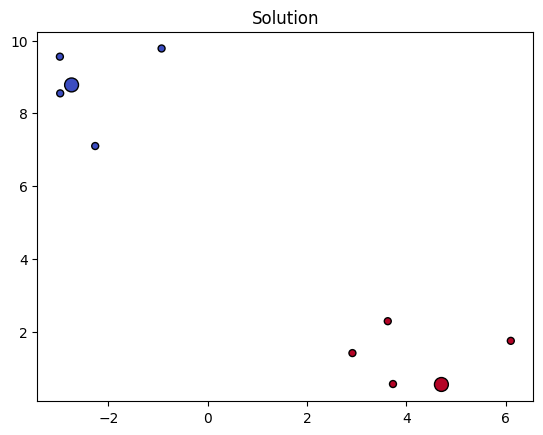

In [18]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()